In [11]:
# Importin packaes
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [12]:
#  Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [14]:
# ivin folder pat
train_path = '/content/gdrive/MyDrive/Drowsiness_detection/dataset_eye/train'
valid_path = '/content/gdrive/MyDrive/Drowsiness_detection/dataset_eye/test'

In [15]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  


In [16]:

  # useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Drowsiness_detection/dataset_eye/train/*')
print("Number of folders,\n",folders)

Number of folders,
 ['/content/gdrive/MyDrive/Drowsiness_detection/dataset_eye/train/Closed', '/content/gdrive/MyDrive/Drowsiness_detection/dataset_eye/train/Open']


In [17]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)


In [18]:
# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [21]:
# Preprocessin te imaes
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Drowsiness_detection/dataset_eye/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Drowsiness_detection/dataset_eye/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1234 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [28]:
num_epochs = 5
training_steps=training_set.n//training_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [29]:
print("Train\n",training_steps)
print("Test\n",validation_steps)

Train
 38
Test
 6


In [30]:
print("Train images\n",training_set.n);print("batch_size\n",training_set.batch_size)

Train images
 1234
batch_size
 32


In [22]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
39/39 [==============================] - 254s 6s/step - loss: 0.4268 - accuracy: 0.8331 - val_loss: 0.1479 - val_accuracy: 0.9587
Epoch 2/5
39/39 [==============================] - 20s 508ms/step - loss: 0.1198 - accuracy: 0.9668 - val_loss: 0.1200 - val_accuracy: 0.9404
Epoch 3/5
39/39 [==============================] - 21s 550ms/step - loss: 0.0949 - accuracy: 0.9611 - val_loss: 0.0857 - val_accuracy: 0.9725
Epoch 4/5
39/39 [==============================] - 23s 587ms/step - loss: 0.0743 - accuracy: 0.9733 - val_loss: 0.0899 - val_accuracy: 0.9633
Epoch 5/5
39/39 [==============================] - 21s 533ms/step - loss: 0.0734 - accuracy: 0.9765 - val_loss: 0.0869 - val_accuracy: 0.9633


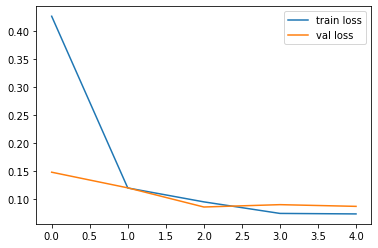

<Figure size 432x288 with 0 Axes>

In [23]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


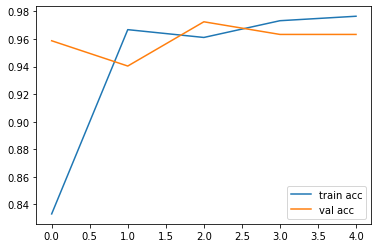

<Figure size 432x288 with 0 Axes>

In [26]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [27]:
# Saving the model
import tensorflow as tf

from keras.models import load_model

model.save('/content/gdrive/MyDrive/Drowsiness_detection/models/Drowsiness_detection_vgg16.h5')